# Лабораторная №3
 
**Задания:**
1. Выбрать временной ряд цен акций.
2. Подготовить данные для обучения моделей машинного обучения (нормализация, создание признаков).
3. Разделить данные на обучающую и тестовую выборки.
4. Реализовать и обучить следующие модели:
   - Логистическая регрессия
   - Машина опорных векторов
   - Модель случайного леса (Random Forest)
   - Градиентный бустинг (например, XGBoost)
5. Настроить гиперпараметры моделей с помощью кросс-валидации.
6. Сделать прогноз на тестовой выборке для каждой модели.
7. Сравнить результаты прогнозирования моделей между собой и с простыми методами (например, наивный прогноз).
8. Визуализировать результаты прогнозирования.
9. Проанализировать важность признаков для моделей, где это применимо.
10. Сделать выводы о эффективности различных подходов машинного обучения в прогнозировании цен акций.


## Описание набора данных
Исторические данные о ежедневных ценах и объемах по американским акциям (AADR), торгуемым на NYSE, NASDAQ и NYSE MKT.

Данные (2010-2017) представлены в формате CSV следующим образом: Дата, Цена открытия актива, Максимум, Минимум, закрытие, Объем, Количество открытых сделок на момент начала торгового дня.

## Загрузка и подготовка данных.
Перед обучением модели, помимо создания признаков: SMA_5, SMA_10, Volatility - скользящие средние и волатильность, все признаки, за исключением целевого показателя, были нормализованы.
Для логистической регрессии, был создан свой целевой показатель - Price Up. Этот показатель равен True, если цена выросла с даты последнего измерения. Иначе он равен False.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
import json

data = pd.read_csv("7_sem_data.csv", parse_dates=True, index_col="Date")

data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['Volatility'] = data['Close'].rolling(window=5).std()
data.dropna(inplace=True)

scaler = StandardScaler()
features = ['Open', 'High', 'Low', 'Volume', 'OpenInt', 'SMA_5', 'SMA_10', 'Volatility']
target = 'Close'
data[features] = scaler.fit_transform(data[features])

# Для регрессии
X_reg = data[features]
y_reg = data['Close']

# Для логистической регрессии
data['Price_Up'] = (data['Close'] > data['Close'].shift(1)).astype(int)
data.dropna(inplace=True)
X_log = data[features]
y_log = data['Price_Up']

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, shuffle=False)
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_log, test_size=0.2, shuffle=False)

## Обучение моделей
Для обучения моделей применялся GridSearchCv. С его помощью выполнялся перебор достаточно большого количества гипер-параметров и осуществлялась кросс-валидация. В качестве оценочной метрики для большинства моделей применялась MAE - среднее абсолютное значение ошибки. Для модели логистической регрессии, которая по сути представляет собой задачу классификации, в которой определяется один из двух классов: вырастет цена или нет, использовалась другая метрика Accuracy - точность.

Также при переборе параметров, обнаруженные оптимальные значения сохранялись в отдельные файлы в формате JSON, чтобы избежать случайной потери результатов длительных вычислений.

In [ ]:
models = {
    'LogisticRegression': {
        'model': LogisticRegression(n_jobs=-1),
        'params': {
            'penalty': ['l1', 'l2', 'elasticnet', None],
            'solver': ['newton-cg', 'lbfgs', 'newton-cholesky', 'liblinear', 'saga', 'sag'],
            'C': [0.01, 0.1, 1, 10, 100]
        },
        'X_train': X_log_train,
        'X_test': X_log_test,
        'y_train': y_log_train,
        'y_test': y_log_test,
        'metric': accuracy_score
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'epsilon': [0.01, 0.1, 0.5, 1],
            'gamma': [
                'scale',
                  'auto',
                    0.1, 1, 10
                    ]
        },
        'X_train': X_reg_train,
        'X_test': X_reg_test,
        'y_train': y_reg_train,
        'y_test': y_reg_test,
        'metric': mean_absolute_error
    },
    'RandomForest': {
        'model': RandomForestRegressor(n_jobs=-1),
        'params': {
            'n_estimators': [50, 100,200, 500],
            'max_depth': [None, 5, 10, 15, 20],
            'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
            'max_features': ['sqrt','log2',None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'X_train': X_reg_train,
        'X_test': X_reg_test,
        'y_train': y_reg_train,
        'y_test': y_reg_test,
        'metric': mean_absolute_error
    },
    'XGBoost': {
        'model': XGBRegressor(n_jobs=-1),
        'params': {
            'n_estimators': [50, 100, 200, 500],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 6, 10, 12],
            'subsample': [0.5, 0.7, 1.0],
            'colsample_bytree': [0.5, 0.7, 1.0],
            'gamma': [0, 0.1, 0.5, 1]
        },
        'X_train': X_reg_train,
        'X_test': X_reg_test,
        'y_train': y_reg_train,
        'y_test': y_reg_test,
        'metric': mean_absolute_error
    }
}

results = {}
for title, config in models.items():
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='neg_mean_absolute_error' if title != 'LogisticRegression' else 'accuracy',
        n_jobs=-1
    )
    grid.fit(config['X_train'], config['y_train'])
    
    best_params = grid.best_params_
    predictions = grid.predict(config['X_test'])
    
    metric_value = config['metric'](config['y_test'], predictions)
    results[title] = {
        'best_params': best_params,
        'metric_value': metric_value
    }
    
    with open(f'{title}_best_params.json', 'w') as f:
        json.dump({'best_params': best_params, 'metric_value': metric_value}, f, indent=4)

## Прогнозирование
Затем на основе полученных параметров, были сформированы модели. Помимо них в качестве наивного прогноза применялись два метода: скользящее среднее за неделю, и случайное изменение цены на небольшое значение в пределах 1%.
На основе прогнозов каждой модели, были построены графики и вычислены метрики.

SVR MAE: 0.1320, RMSE: 0.1992


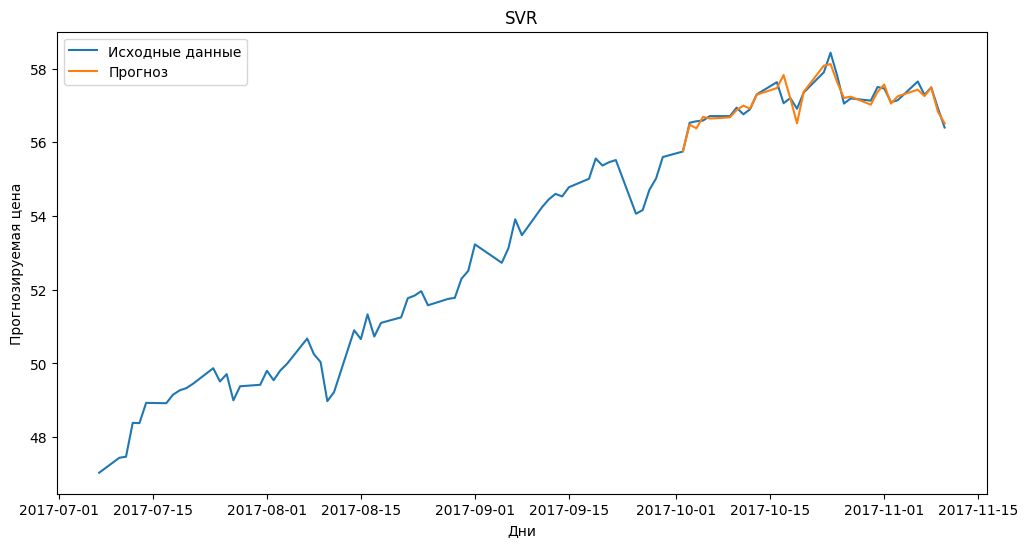

Random Forest MAE: 1.6999, RMSE: 1.7748


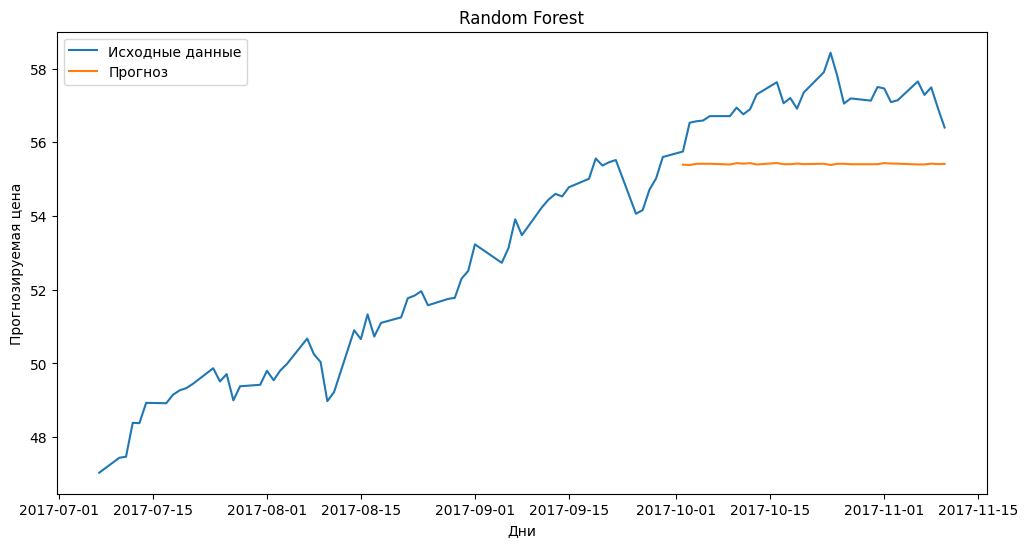

XG Boost MAE: 1.6843, RMSE: 1.7622


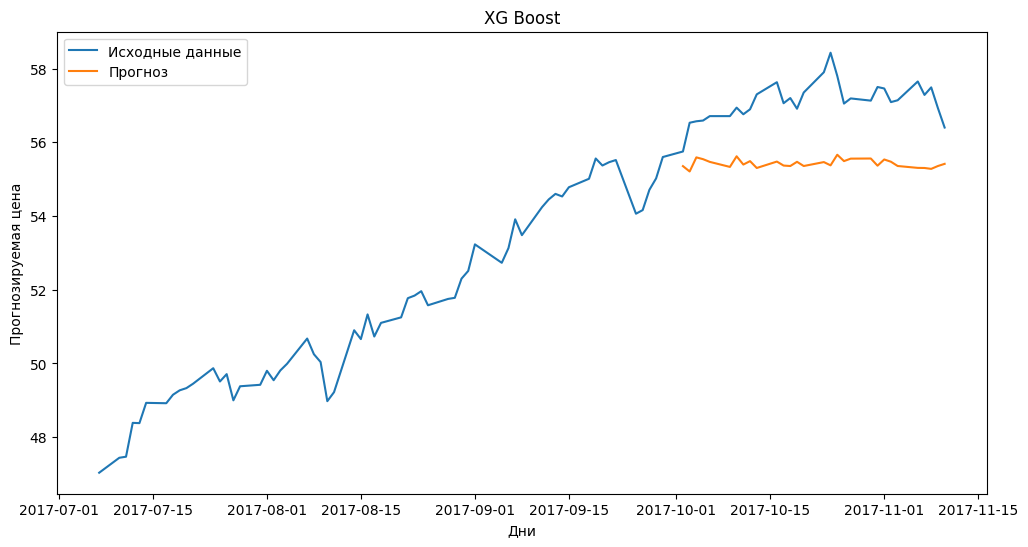

[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 0]
Logistic Regression Точность предсказания колебаний: 0.8
Скользящее среднее (окно = 50) MAE: 0.3837, RMSE: 0.5105


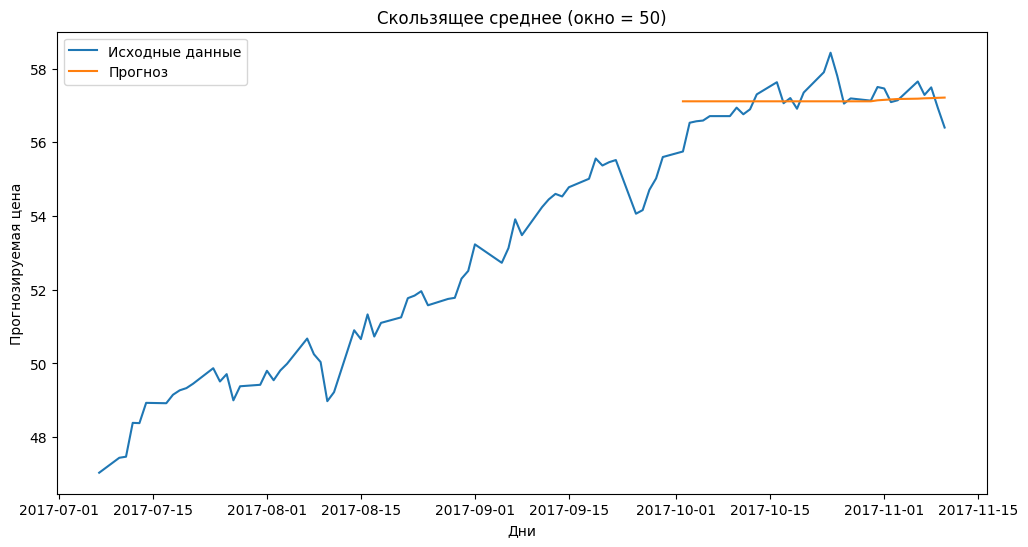

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Случайные скачки Точность предсказания колебаний: 0.4
Случайные скачки MAE: 1.2972, RMSE: 1.3961


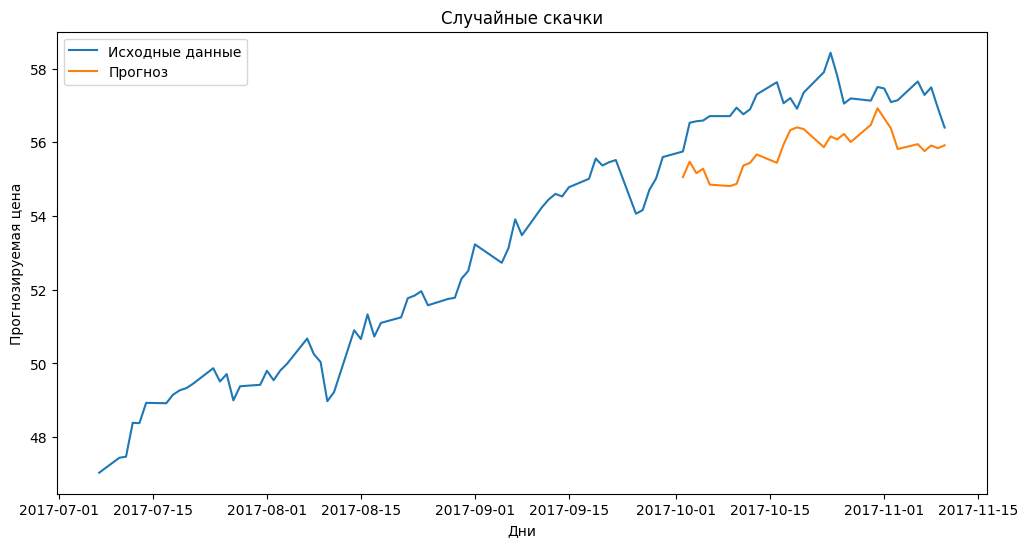

In [34]:
SVR_model = SVR(C=100,epsilon=0.01,gamma='auto',kernel='linear')
RF_model = RandomForestRegressor(n_jobs=-1,max_depth=15, criterion='squared_error',max_features=None,min_samples_leaf=1,min_samples_split=2,n_estimators=50)
XGB_model = XGBRegressor(n_jobs=-1,colsample_bytree= 0.7,gamma= 0,learning_rate= 0.1,max_depth= 3,n_estimators= 500,subsample= 1.0)
LR_model = LogisticRegression(n_jobs=-1,C=10,penalty="l2", solver="lbfgs")
forecast_models = {
    "SVR": SVR_model,
    "Random Forest": RF_model,
    "XG Boost": XGB_model,
    "Logistic Regression": LR_model,
}
def forecast_price(forecast, title):
    if title == 'Logistic Regression':
        print(forecast)
        print(f'{title} Точность предсказания колебаний: {accuracy_score(data['Price_Up'].iloc[-30:], forecast)}')
        return
    if title == 'Случайные скачки':
        forecast2 = (forecast > data['Close'].shift(1).iloc[-30:].values).astype(int)
        print(forecast2)
        print(f'{title} Точность предсказания колебаний: {accuracy_score(data['Price_Up'].iloc[-30:], forecast2)}')
    mae = mean_absolute_error(data[target].iloc[-30:], forecast)
    rmse = np.sqrt(mean_squared_error(data[target].iloc[-30:], forecast))
    print(f'{title} MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    plt.figure(figsize=(12, 6))
    plt.plot(data.iloc[-90:].index,data[target].iloc[-90:])
    plt.plot(data.iloc[-30:].index,forecast)
    plt.title(title)
    plt.xlabel('Дни')
    plt.ylabel('Прогнозируемая цена')
    plt.legend(['Исходные данные','Прогноз'])
    plt.show()
for title, model in forecast_models.items():
    if title == 'Logistic Regression':
         model.fit(data[features].iloc[:-30],data["Price_Up"].iloc[:-30])
    else:
        model.fit(data[features].iloc[:-30],data[target].iloc[:-30])
    forecast_price(model.predict(data[features].iloc[-30:]),title)

def forecast_with_moving_average():
    forecast_values = []
    current_window = data[target].iloc[-30:].tail(50).tolist()
    for _ in range(30):
        new_value = np.mean(current_window)
        forecast_values.append(new_value)
        current_window.append(new_value)
        if len(current_window) > 50:
            current_window.pop(0)
    return forecast_values

forecast_price(forecast_with_moving_average(), "Скользящее среднее (окно = 50)")
def random_change_forecast():
    last_price = data[target].iloc[-31]
    forecast = []
    for _ in range(30):
        change_percentage = np.random.uniform(-0.01, 0.01)
        new_price = last_price * (1 + change_percentage)
        forecast.append(new_price)
        last_price = new_price
    return forecast
forecast_price(random_change_forecast(), "Случайные скачки")

## Оценка признаков
Большинство использованных моделей, уже хранят в себе важность признаков: Logistic Regression, Random forest, XG Boost. Остаётся только их извлечь. В отличие от остальных SVR такую информацию не содержит, и для оценки важности его признаков можно воспользоваться Permutation Importance. Permutation Importance — это метод, используемый в машинном обучении для определения важности отдельных признаков в отношении прогноза, сделанного моделью. 

*Принцип работы: произвольным образом переставить или перетасовать один столбец в наборе датасета валидации, оставив все остальные столбцы нетронутыми. Признак считается «важным», если точность модели падает и его изменение вызывает увеличение ошибок. С другой стороны, признак считается «неважным», если перетасовка его значений не влияет на точность модели.*

In [ ]:
feature_importance_log = pd.DataFrame({
    'Признак': X_log_train.columns,
    'Важность': LR_model.coef_[0]
}).sort_values(by='Важность', ascending=False)
print('Logistic Regression')
print(feature_importance_log)

feature_importance_rf = pd.DataFrame({
    'Признак': X_reg_train.columns,
    'Важность': RF_model.feature_importances_
}).sort_values(by='Важность', ascending=False)
print('Random forest')
print(feature_importance_rf)

feature_importance_xgb = pd.DataFrame({
    'Признак': X_reg_train.columns,
    'Важность': XGB_model.feature_importances_
}).sort_values(by='Важность', ascending=False)
print('XG Boost')
print(feature_importance_xgb)

from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(SVR_model, X_reg_test, y_reg_test, n_repeats=10, random_state=42)
feature_importance_svr = pd.DataFrame({
    'Признак': X_reg_test.columns,
    'Важность': perm_importance.importances_mean
}).sort_values(by='Важность', ascending=False)
print('SVR')
print(feature_importance_svr)



Logistic Regression
      Признак   Важность
2         Low  12.972534
1        High  10.293144
6      SMA_10   1.539572
3      Volume   0.182104
7  Volatility   0.135724
4     OpenInt   0.000000
0        Open  -8.628643
5       SMA_5 -16.225243
Random forest
      Признак  Важность
1        High  0.658516
2         Low  0.145515
0        Open  0.075291
6      SMA_10  0.065727
5       SMA_5  0.054839
7  Volatility  0.000068
3      Volume  0.000045
4     OpenInt  0.000000
XG Boost
      Признак  Важность
1        High  0.484845
2         Low  0.355317
5       SMA_5  0.129659
0        Open  0.029597
6      SMA_10  0.000441
3      Volume  0.000073
7  Volatility  0.000068
4     OpenInt  0.000000
SVR
      Признак  Важность
1        High  1.496618
2         Low  1.384586
0        Open  1.010694
5       SMA_5  0.000549
6      SMA_10  0.000003
4     OpenInt  0.000000
7  Volatility -0.000002
3      Volume -0.000012


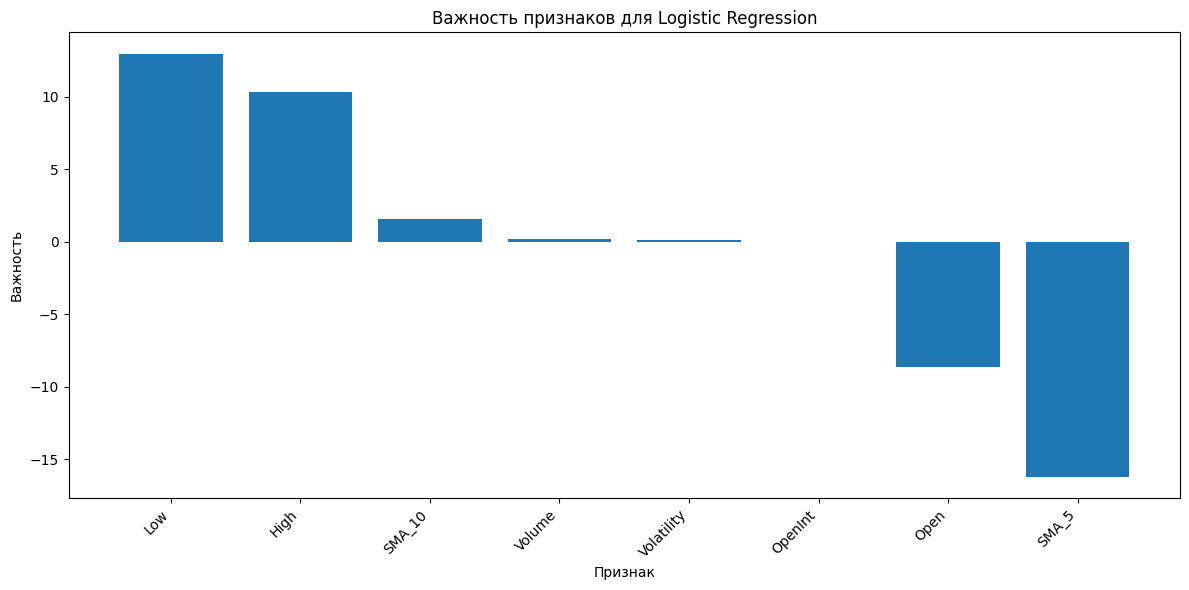

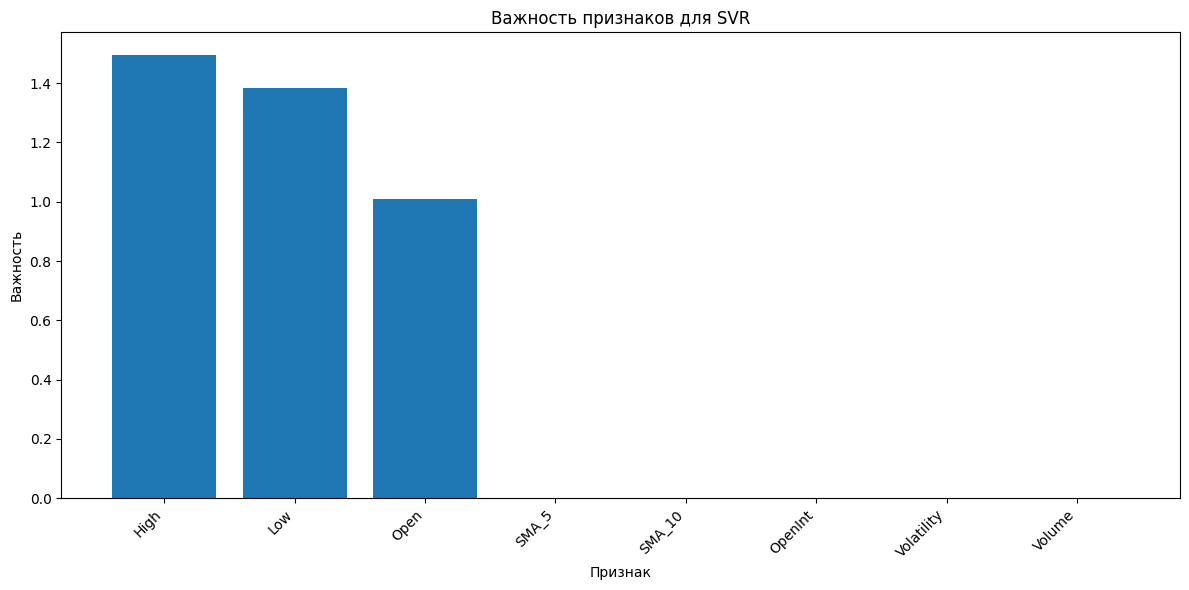

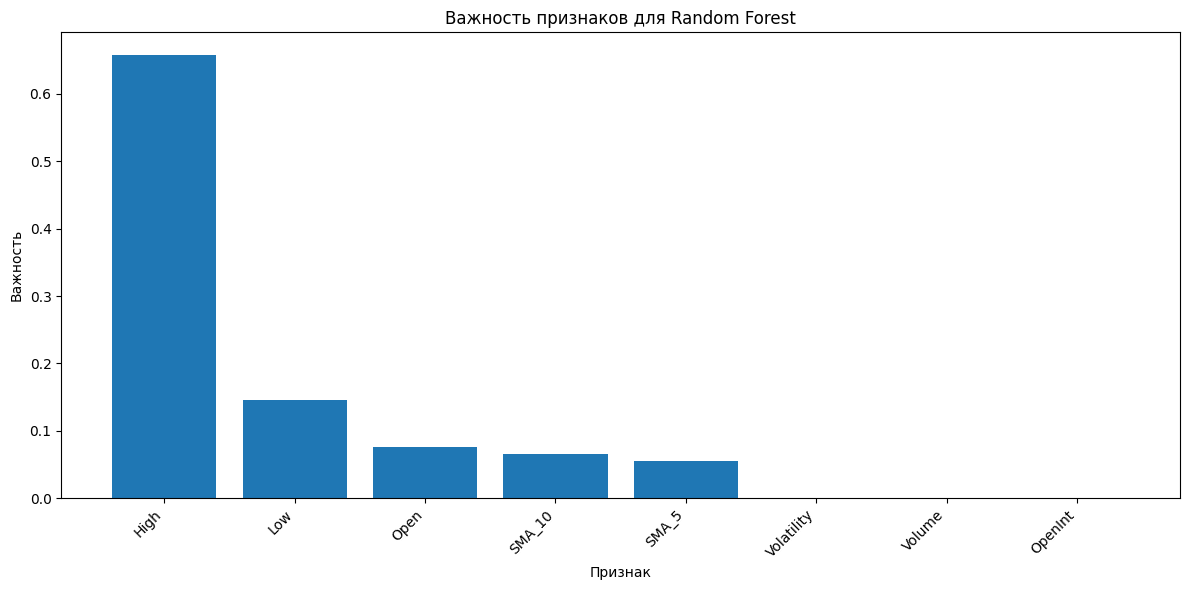

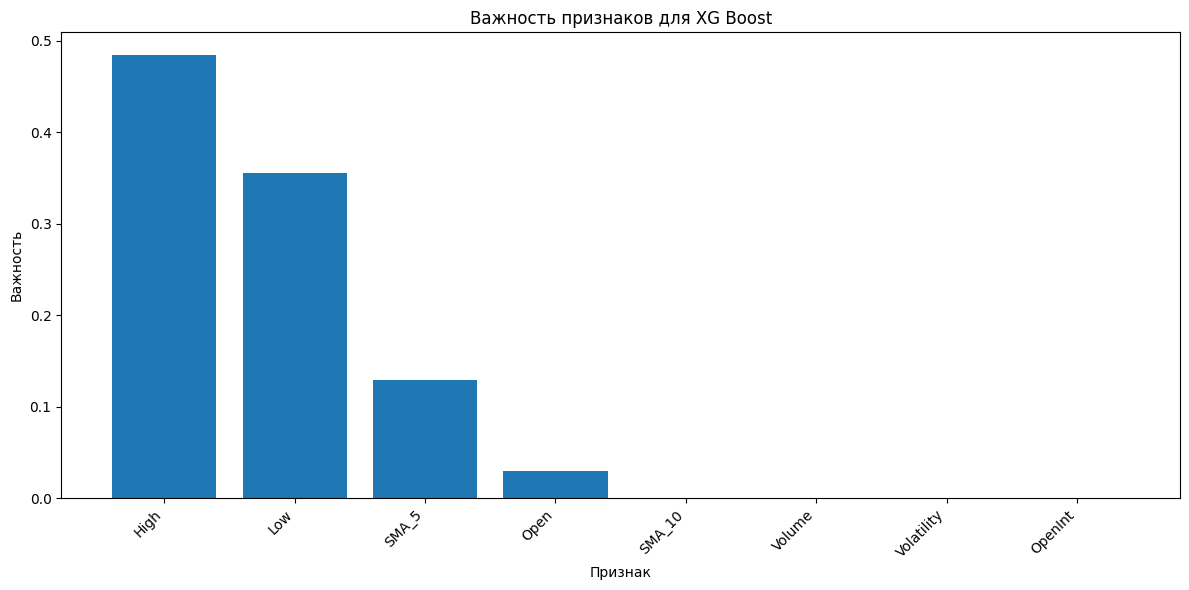

In [28]:
def plot_feature_importance(feature_importance, model_name):
    features = feature_importance['Признак']
    importances = feature_importance['Важность']
    plt.figure(figsize=(12, 6))
    plt.bar(features, importances)
    plt.xlabel('Признак')
    plt.ylabel('Важность')
    plt.title(f'Важность признаков для {model_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_feature_importance(feature_importance_log, 'Logistic Regression')
plot_feature_importance(feature_importance_svr, 'SVR')
plot_feature_importance(feature_importance_rf, 'Random Forest')
plot_feature_importance(feature_importance_xgb, 'XG Boost')


## Заключение

**Удивительно хорошо себя показала модель SVR. Абсолютная погрешность составила всего в районе 13 центов, при общем порядке величин в районе 56 долларов.**

Остальные модели в задаче регрессии себя показали куда хуже. Если расставить модели в порядке успешностиЮ то получится следующий ряд:

**SVR > Скользящее среднее > Случайные скачки ~ XG Boost ~ Random Forest.**

Скользящее среднее, хотя и выглядит абсолютно абсурдным для прогноза, показало результаты лучшие чем XG Boost и Random Forest. Т.е. XG Boost и Random Forest показали себя абсолютно неприменимым в данной задаче. Эти модели не уловили тренд на возрастание цены с течением времени. Случайные скачки, показывают себя чересчур случайно, и точность прогноза зависит от прогона.

Достаточно хорошо себя показала логистическая регрессия. Её точность составила 80%.

Достаточно интересно может быть посмотрев на графики моделей, оценивающих важность признаков. Так SVR, в отличие от других моделей примененных для решения задачи регрессии, фокусируется на признаках High, Low, Open. Причём High, Low достаточно близки, но всё же отличаются по значимости, а Open немного менее значим чем оба другие.

Модели же Random forest же оценивает больше всего High, затем значительно ниже Low, после ещё в 2 раза ниже Open, а потом уже практически вровень следует SMA_10 и SMA_5.

XG Boost оценил признаки в виде своеобразной лесенки High > Low > SMA_5 > Open. Что интересно, SMA_10 он практически не использует, в отличие от SMA_5.

Значения коэффициентов Логистической регрессии особенны тем, что в отличие от всех остальных моделей, можно увидеть не значительное, но все же применение созданного признака Volatility и Volume.

**Главный вывод, который можно сделать анализируя важность признаков моделей, это возможность исключить некоторые из них при использовании. Это точно повысит скорость вычислений моделей и вполне может улучшить результаты (незначительно). Для всех моделей можно совершенно точно отбросить признак OpenInt (число открытых сделок на начало дня), для всех моделей можно отбросить признаки Volatility и Volume.**